# 🧪 SigmaHeat Energy Assessment – Jupyter Notebook

Dieses Notebook enthält das Grundgerüst zur Bearbeitung der Mini-Assessment-Aufgabe zur Analyse von Energieverbrauchsdaten.

## 1. 📥 Daten einlesen & vorbereiten

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV einlesen
df = pd.read_csv("data/sigmaheat_energy_simulation.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

# Überblick
df.head()

,energy_kwh,outside_temp,flow_temp,return_temp,device_id
timestamp,,,,,
2024-01-01 00:00:00,5.593250,3.631284,58.775046,51.496937,H01
2024-01-01 00:15:00,5.145941,7.458857,54.861587,49.304719,H01
2024-01-01 00:30:00,6.110562,5.541851,58.053161,54.572573,H01
2024-01-01 00:45:00,7.542448,5.676523,57.464892,53.310090,H01
2024-01-01 01:00:00,6.058304,1.231516,58.748980,52.327981,H01


# 1.5 Correlation Matrix

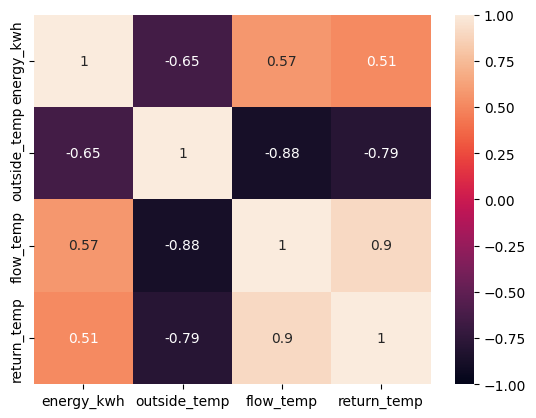

In [10]:
corr = df.corr(numeric_only=True)
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

## 2. 🔍 Explorative Datenanalyse (EDA)

In [12]:
import numpy as np

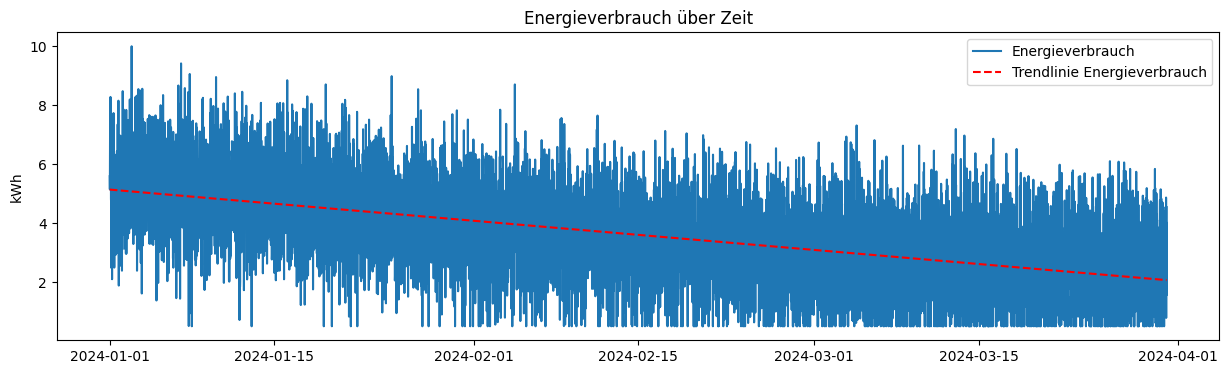

In [13]:
# Energieverbrauch über Zeit
plt.figure(figsize=(15, 4))
plt.plot(df.index, df["energy_kwh"], label="Energieverbrauch")

# Calculate trend line
# Convert index to numerical values for polyfit
x_numeric = np.arange(len(df.index))
z = np.polyfit(x_numeric, df["energy_kwh"], 1)
p = np.poly1d(z)
plt.plot(df.index, p(x_numeric), "r--", label="Trendlinie Energieverbrauch")

plt.title("Energieverbrauch über Zeit")
plt.ylabel("kWh")
plt.legend()
plt.show()


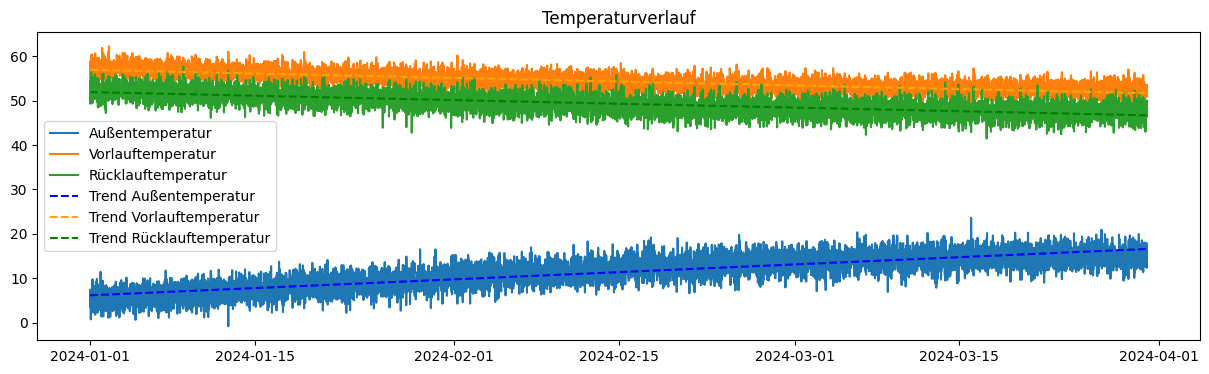

In [14]:
# Temperaturverlauf
plt.figure(figsize=(15, 4))
plt.plot(df.index, df["outside_temp"], label="Außentemperatur")
plt.plot(df.index, df["flow_temp"], label="Vorlauftemperatur")
plt.plot(df.index, df["return_temp"], label="Rücklauftemperatur")

# Calculate and plot trend line for outside_temp
z_outside = np.polyfit(x_numeric, df["outside_temp"], 1)
p_outside = np.poly1d(z_outside)
plt.plot(df.index, p_outside(x_numeric), "--", color="blue", label="Trend Außentemperatur")

# Calculate and plot trend line for flow_temp
z_flow = np.polyfit(x_numeric, df["flow_temp"], 1)
p_flow = np.poly1d(z_flow)
plt.plot(df.index, p_flow(x_numeric), "--", color="orange", label="Trend Vorlauftemperatur")

# Calculate and plot trend line for return_temp
z_return = np.polyfit(x_numeric, df["return_temp"], 1)
p_return = np.poly1d(z_return)
plt.plot(df.index, p_return(x_numeric), "--", color="green", label="Trend Rücklauftemperatur")

plt.title("Temperaturverlauf")
plt.legend()
plt.show()

## 3. 🛠️ Feature Engineering

In [15]:
# Zeitmerkmale
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = df["dayofweek"] >= 5

# Temperaturdifferenzen
df["delta_temp"] = df["flow_temp"] - df["return_temp"]
df["heating_demand"] = 16 - df["outside_temp"]
df["heating_demand"] = df["heating_demand"].clip(lower=0)

# Rolling Average Beispiel
df["rolling_energy_6h"] = df["energy_kwh"].rolling(window=24).mean()

## 4. 📈 Modellierung – Tagesverbrauch prognostizieren

In [ ]:
# Tagesweise aggregieren
daily = df.resample("D").sum()

# Ziel: Verbrauch des nächsten Tages
daily["next_day_energy"] = daily["energy_kwh"].shift(-1)
daily = daily.dropna()

# Beispiel-Features
X = daily[["energy_kwh"]]
y = daily["next_day_energy"]

# Modelltraining
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)



MAE: 30.244105449470048


TypeError: got an unexpected keyword argument 'squared'

In [18]:
# Evaluation
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

MAE: 30.244105449470048
RMSE: 2264.823751079993


## 5. 💡 Optimierungspotenziale identifizieren

- Zeiten mit überdurchschnittlichem Verbrauch erkennen
- Wochenendverbrauch analysieren
- Mögliche Maßnahmen ableiten

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8641 entries, 2024-01-01 00:00:00 to 2024-03-31 00:00:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy_kwh         8641 non-null   float64
 1   outside_temp       8641 non-null   float64
 2   flow_temp          8641 non-null   float64
 3   return_temp        8641 non-null   float64
 4   device_id          8641 non-null   object 
 5   hour               8641 non-null   int32  
 6   dayofweek          8641 non-null   int32  
 7   is_weekend         8641 non-null   bool   
 8   delta_temp         8641 non-null   float64
 9   heating_demand     8641 non-null   float64
 10  rolling_energy_6h  8618 non-null   float64
dtypes: bool(1), float64(7), int32(2), object(1)
memory usage: 683.5+ KB


<Axes: xlabel='dayofweek'>

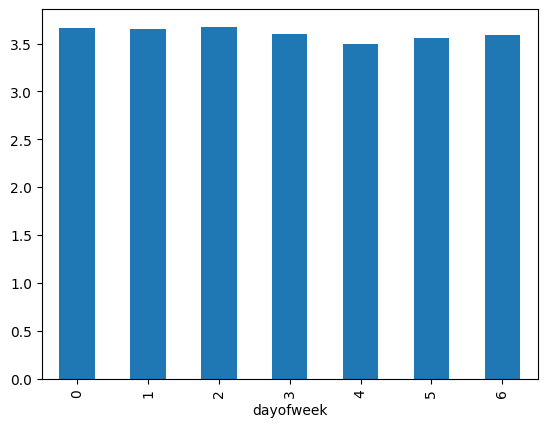

In [43]:
df.groupby(["dayofweek"])["energy_kwh"].mean().plot.bar()

<Axes: xlabel='dayofweek', ylabel='energy_kwh'>

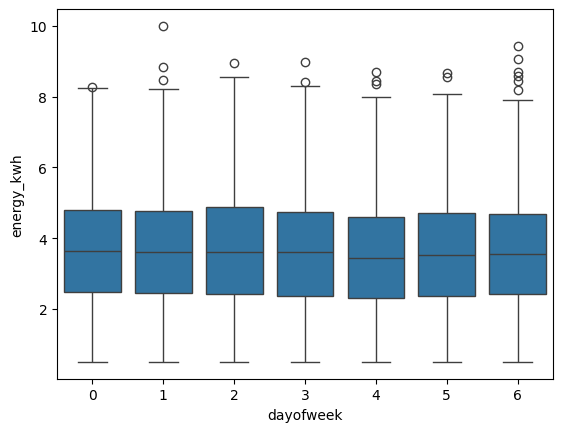

In [44]:
sns.boxplot(data=df, x="dayofweek", y="energy_kwh")

In [45]:
df.head()

,energy_kwh,outside_temp,flow_temp,return_temp,device_id,hour,dayofweek,is_weekend,delta_temp,heating_demand,rolling_energy_6h
timestamp,,,,,,,,,,,
2024-01-01 00:00:00,5.593250,3.631284,58.775046,51.496937,H01,0,0,False,7.278109,12.368716,NaN
2024-01-01 00:15:00,5.145941,7.458857,54.861587,49.304719,H01,0,0,False,5.556868,8.541143,NaN
2024-01-01 00:30:00,6.110562,5.541851,58.053161,54.572573,H01,0,0,False,3.480588,10.458149,NaN
2024-01-01 00:45:00,7.542448,5.676523,57.464892,53.310090,H01,0,0,False,4.154802,10.323477,NaN
2024-01-01 01:00:00,6.058304,1.231516,58.748980,52.327981,H01,1,0,False,6.420999,14.768484,NaN


In [50]:
df.device_id.nunique()

1